# Homework 6

**Due: 10/27/2020 on gradescope**

## References

+ Lectures 17-18 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - You can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope.

+ The total homework points are 100. Please note that the problems are not weighed equally.

**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name:**
+ **Last Name:**
+ **Email:**

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
import scipy.stats as st
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Problem 1 - Clustering Uber Pickup Data

In this problem you will analyze Uber pickup data collected during April 2014 around New York City.
The complete data are freely on [Kaggle](https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city/).
The data consist of a timestamp (which we are going to ignore), the latitude and longitude of the Uber pickup, and a base code (which we are also ignoring).
The data file we are going to use is [uber-raw-data-apr14.csv](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/datasets/uber-raw-data-apr14.csv).
As usual, you have to make it visible to this Jupyter notebook.
On Google Colab, just run this:

In [4]:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/datasets/uber-raw-data-apr14.csv'
download(url)

And you can load it using pandas:

In [6]:
p1_data = pd.read_csv('uber-raw-data-apr14.csv')

Here is a text view:

In [7]:
p1_data

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
564511,4/30/2014 23:22:00,40.7640,-73.9744,B02764
564512,4/30/2014 23:26:00,40.7629,-73.9672,B02764
564513,4/30/2014 23:31:00,40.7443,-73.9889,B02764
564514,4/30/2014 23:32:00,40.6756,-73.9405,B02764


As you see, there where about half a million Uber pickups during April 2014...
Let's extract the lattitude and longitude data only (this is needed for passing them to scikit-learn algorithms).
Here is how you can do this in pandas:

In [8]:
# Just use the column names as indices.
# The two brackets are required because you are actually
# passing a list of columns
loc_data = p1_data[['Lat', 'Lon']]
loc_data

,Lat,Lon
0,40.7690,-73.9549
1,40.7267,-74.0345
2,40.7316,-73.9873
3,40.7588,-73.9776
4,40.7594,-73.9722
...,...,...
564511,40.7640,-73.9744
564512,40.7629,-73.9672
564513,40.7443,-73.9889
564514,40.6756,-73.9405


Let's also visualize these points:

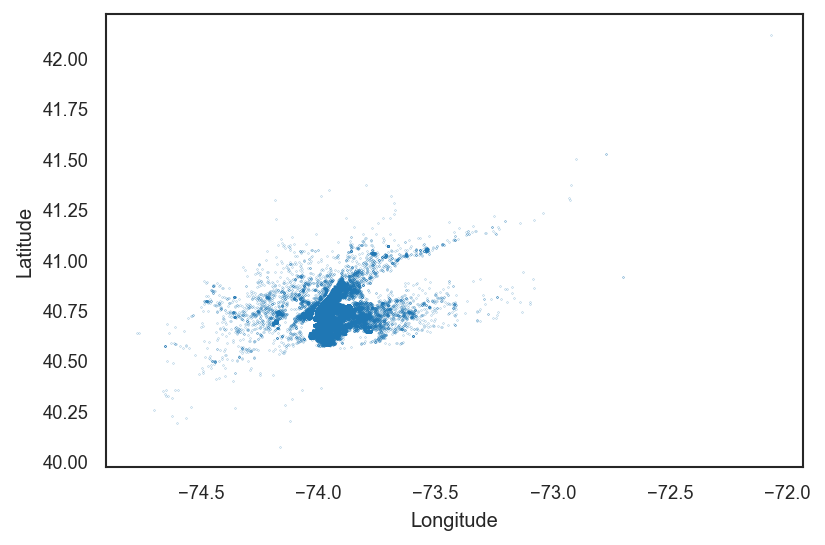

In [16]:
fig, ax = plt.subplots(dpi=150)
ax.scatter(loc_data.Lon, loc_data.Lat, s=0.01)
# ``s=0.01`` specifies the size. I am using a small size because
# these are too many points to visualize
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');

This is nice, but it would be even nicer if we had a map of New York City on the background.
We can make such a map on [www.openstreetmap.org](https://www.openstreetmap.org/export#map=11/40.7855/-73.8964).
We just need to have a box of longitude's and latitudes that overlaps with our data.
Here is how to get such a *bounding box*:

In [36]:
box = ((loc_data.Lon.min(), loc_data.Lon.max(),
        loc_data.Lat.min(), loc_data.Lat.max()))
box

(-74.7733, -72.0666, 40.0729, 42.1166)

I have already extracted this picture for you and you can find it [here](https://github.com/PredictiveScienceLab/data-analytics-se/blob/master/datasets/map_ny.png).
As always, it needs to be visible from the Jupyter notebook.
On Google Colab run:

In [33]:
url = 'https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/datasets/map_ny.png'
download(url)

If you have it at the right place, you should be able to see the image here:

![New York City Map](map_ny.png)

Now let's load the image as a matrix:

In [34]:
ny_map = plt.imread('map_ny.png')

And we can visualize it with ``plt.imshow`` and draw the Uber pickups on top of it.
Here is how:

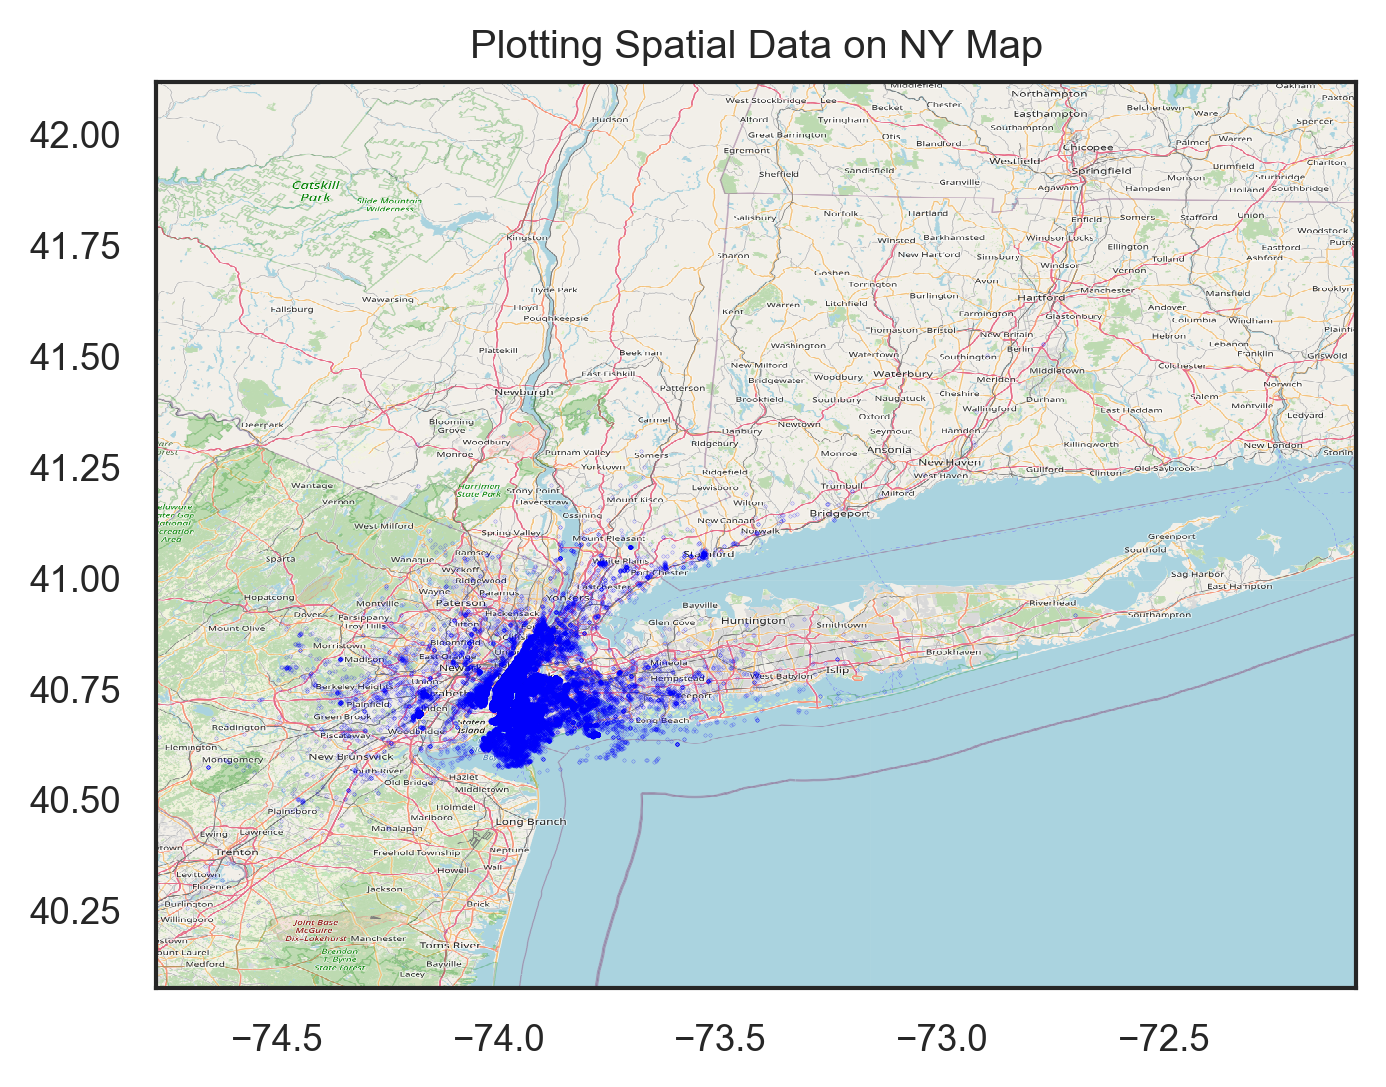

In [40]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(loc_data.Lon, loc_data.Lat, zorder=1, alpha= 0.5, c='b', s=0.01)
ax.set_title('Plotting Spatial Data on NY Map')
ax.set_xlim(box[0],box[1])
ax.set_ylim(box[2],box[3])
ax.imshow(ny_map, zorder=0, extent=box, aspect= 'equal')

# Problem 2 - Counting Celestial Objects

Write.

# Problem 3 - Quantifying Uncertainties in Steel Magnetic Properties

Write.

*Enter your model description/solution here. Delete that ``<br>`` line (it just makes some white space).*
<br><br><br><br><br><br><br><br><br><br>